# Table of contents
* [Import libraries and dataset](#Import-libraries-and-dataset)
* [Descriptive analysis of the data](#Descriptive-analysis-of-the-data)
* [Feature engineering, data cleaning](#-Feature-engineering,-data-cleaning)
    * [Division of the dataset into training and test datasets](#Division-of-the-dataset-into-training-and-test-datasets)
    * [Handling missing data](#-Handling-missing-data)
* [Logistic Regression](#Logistic-Regression)
* [XGBoost](#XGBoost)
* [Decision trees](#Decision-trees)
* [Decision trees with RFE](#Decision-trees-with-RFE)
* [Suport Vector Machine (SVM)](#Suport-Vector-Machine-(SVM))


# Import libraries and dataset

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import scipy.stats
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from datetime import datetime
from IPython.display import display_html 
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

%matplotlib inline

warnings.filterwarnings("ignore")

We start the analyzed dataset *GymSubs.csv*.

In [160]:
df =  pd.read_excel('data/GymSubs.xlsx').drop(['user_id'], axis=1)

# Descriptive analysis of the data

In [161]:
df.head()

,target,name,sex,dob,location,location_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type
0,1,Halina,NaN,1982-08-07,Piastów,22732,Teaching professionals,Fitness,46.0,196,Single,NaN,Visa
1,0,Eustachy,male,1971-10-28,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.0,243,Single,NaN,NaN
2,1,Egon,NaN,2000-07-05,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.0,191,In relationship,3.0,NaN
3,0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Customer services clerks,Badminton,88.0,164,In relationship,3.0,Visa
4,0,Hilary,NaN,1975-01-09,Osieczna,2322,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.0,119,Married with kids,5.0,NaN


Columns name, occupation, hobbies will be hard to analyze.

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   target               4000 non-null   int64         
 1   name                 3982 non-null   object        
 2   sex                  3616 non-null   object        
 3   dob                  3606 non-null   datetime64[ns]
 4   location             4000 non-null   object        
 5   location_population  4000 non-null   int64         
 6   occupation           4000 non-null   object        
 7   hobbies              3320 non-null   object        
 8   daily_commute        3595 non-null   float64       
 9   friends_number       4000 non-null   int64         
 10  relationship_status  3607 non-null   object        
 11  education            3592 non-null   float64       
 12  credit_card_type     3572 non-null   object        
dtypes: datetime64[ns](1), float64(2),

The dataset consists of 13 variables, eight of which have missing data.

In [163]:
# Table with sum of Na values 

# Create a list of counts of non-null values for each column in df
# Create a list of counts of NA (null) values for each column in df
# Create a list of formatted percentages showing the proportion of NA values in each column.
# Set the row names (index) in 'NA' to describe the information provided in each row.
def data_na(df):
    NA = pd.DataFrame(data=[df.notna().sum().tolist(), 
                df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['Not NA Count', 'NA Count', 'NA Percent']).transpose()
    return NA
data_na(df)

,Not NA Count,NA Count,NA Percent
target,4000,0,0.00%
name,3982,18,0.45%
sex,3616,384,9.60%
dob,3606,394,9.85%
location,4000,0,0.00%
location_population,4000,0,0.00%
occupation,4000,0,0.00%
hobbies,3320,680,17.00%
daily_commute,3595,405,10.12%
friends_number,4000,0,0.00%


Hobbies have the largest percentage share at 17.00 %

In [164]:
df.describe()

,target,dob,location_population,daily_commute,friends_number,education
count,4000.000000,3606,4.000000e+03,3595.000000,4000.000000,3592.000000
mean,0.201500,1979-01-23 11:32:50.715474240,3.105877e+05,50.098748,199.877750,3.670935
min,0.000000,1922-05-27 00:00:00,7.860000e+02,0.000000,0.000000,1.000000
25%,0.000000,1969-06-28 06:00:00,2.435725e+04,25.000000,143.000000,3.000000
50%,0.000000,1979-07-03 12:00:00,8.007200e+04,50.000000,199.000000,4.000000
75%,0.000000,1989-05-05 00:00:00,3.523130e+05,75.000000,256.000000,5.000000
max,1.000000,2001-11-10 00:00:00,1.764615e+06,99.000000,619.000000,6.000000
std,0.401171,NaN,4.878360e+05,28.806060,90.494937,1.327582


Data looks good with no anomalies

In [165]:
# General statistics of qualitative variables
df.describe(include=['O'])

,name,sex,location,occupation,hobbies,relationship_status,credit_card_type
count,3982,3616,4000,4000,3320,3607,3572
unique,208,2,645,43,2745,5,4
top,Franciszek,female,Warszawa,Science and engineering associate professionals,Gym,In relationship,Visa
freq,38,2040,332,106,20,1247,1777


We have 6 categorical variables, three of which have very unique values.

# Target variable

In [166]:
df['target'].value_counts()

target
0    3194
1     806
Name: count, dtype: int64

In [167]:
# Representation of the abundance of the explanatory variable in percentage form
df['target'].value_counts(normalize=True)

target
0    0.7985
1    0.2015
Name: proportion, dtype: float64

As you can see, only about 20% of customers are our target. 

<Axes: xlabel='target', ylabel='count'>

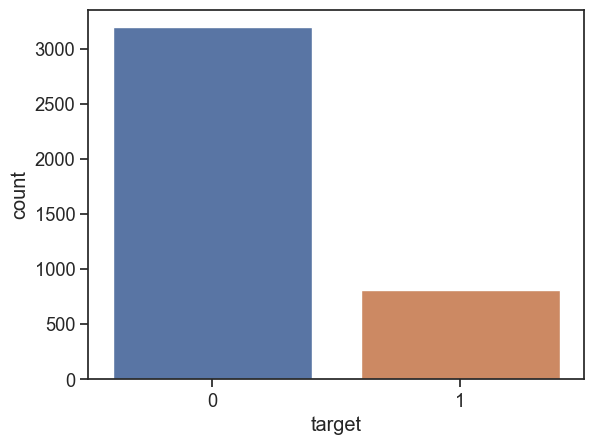

In [168]:
sns.countplot(x = 'target', data=df)

The vast majority of opservers are people who are not our target audience

#### Categorical variables

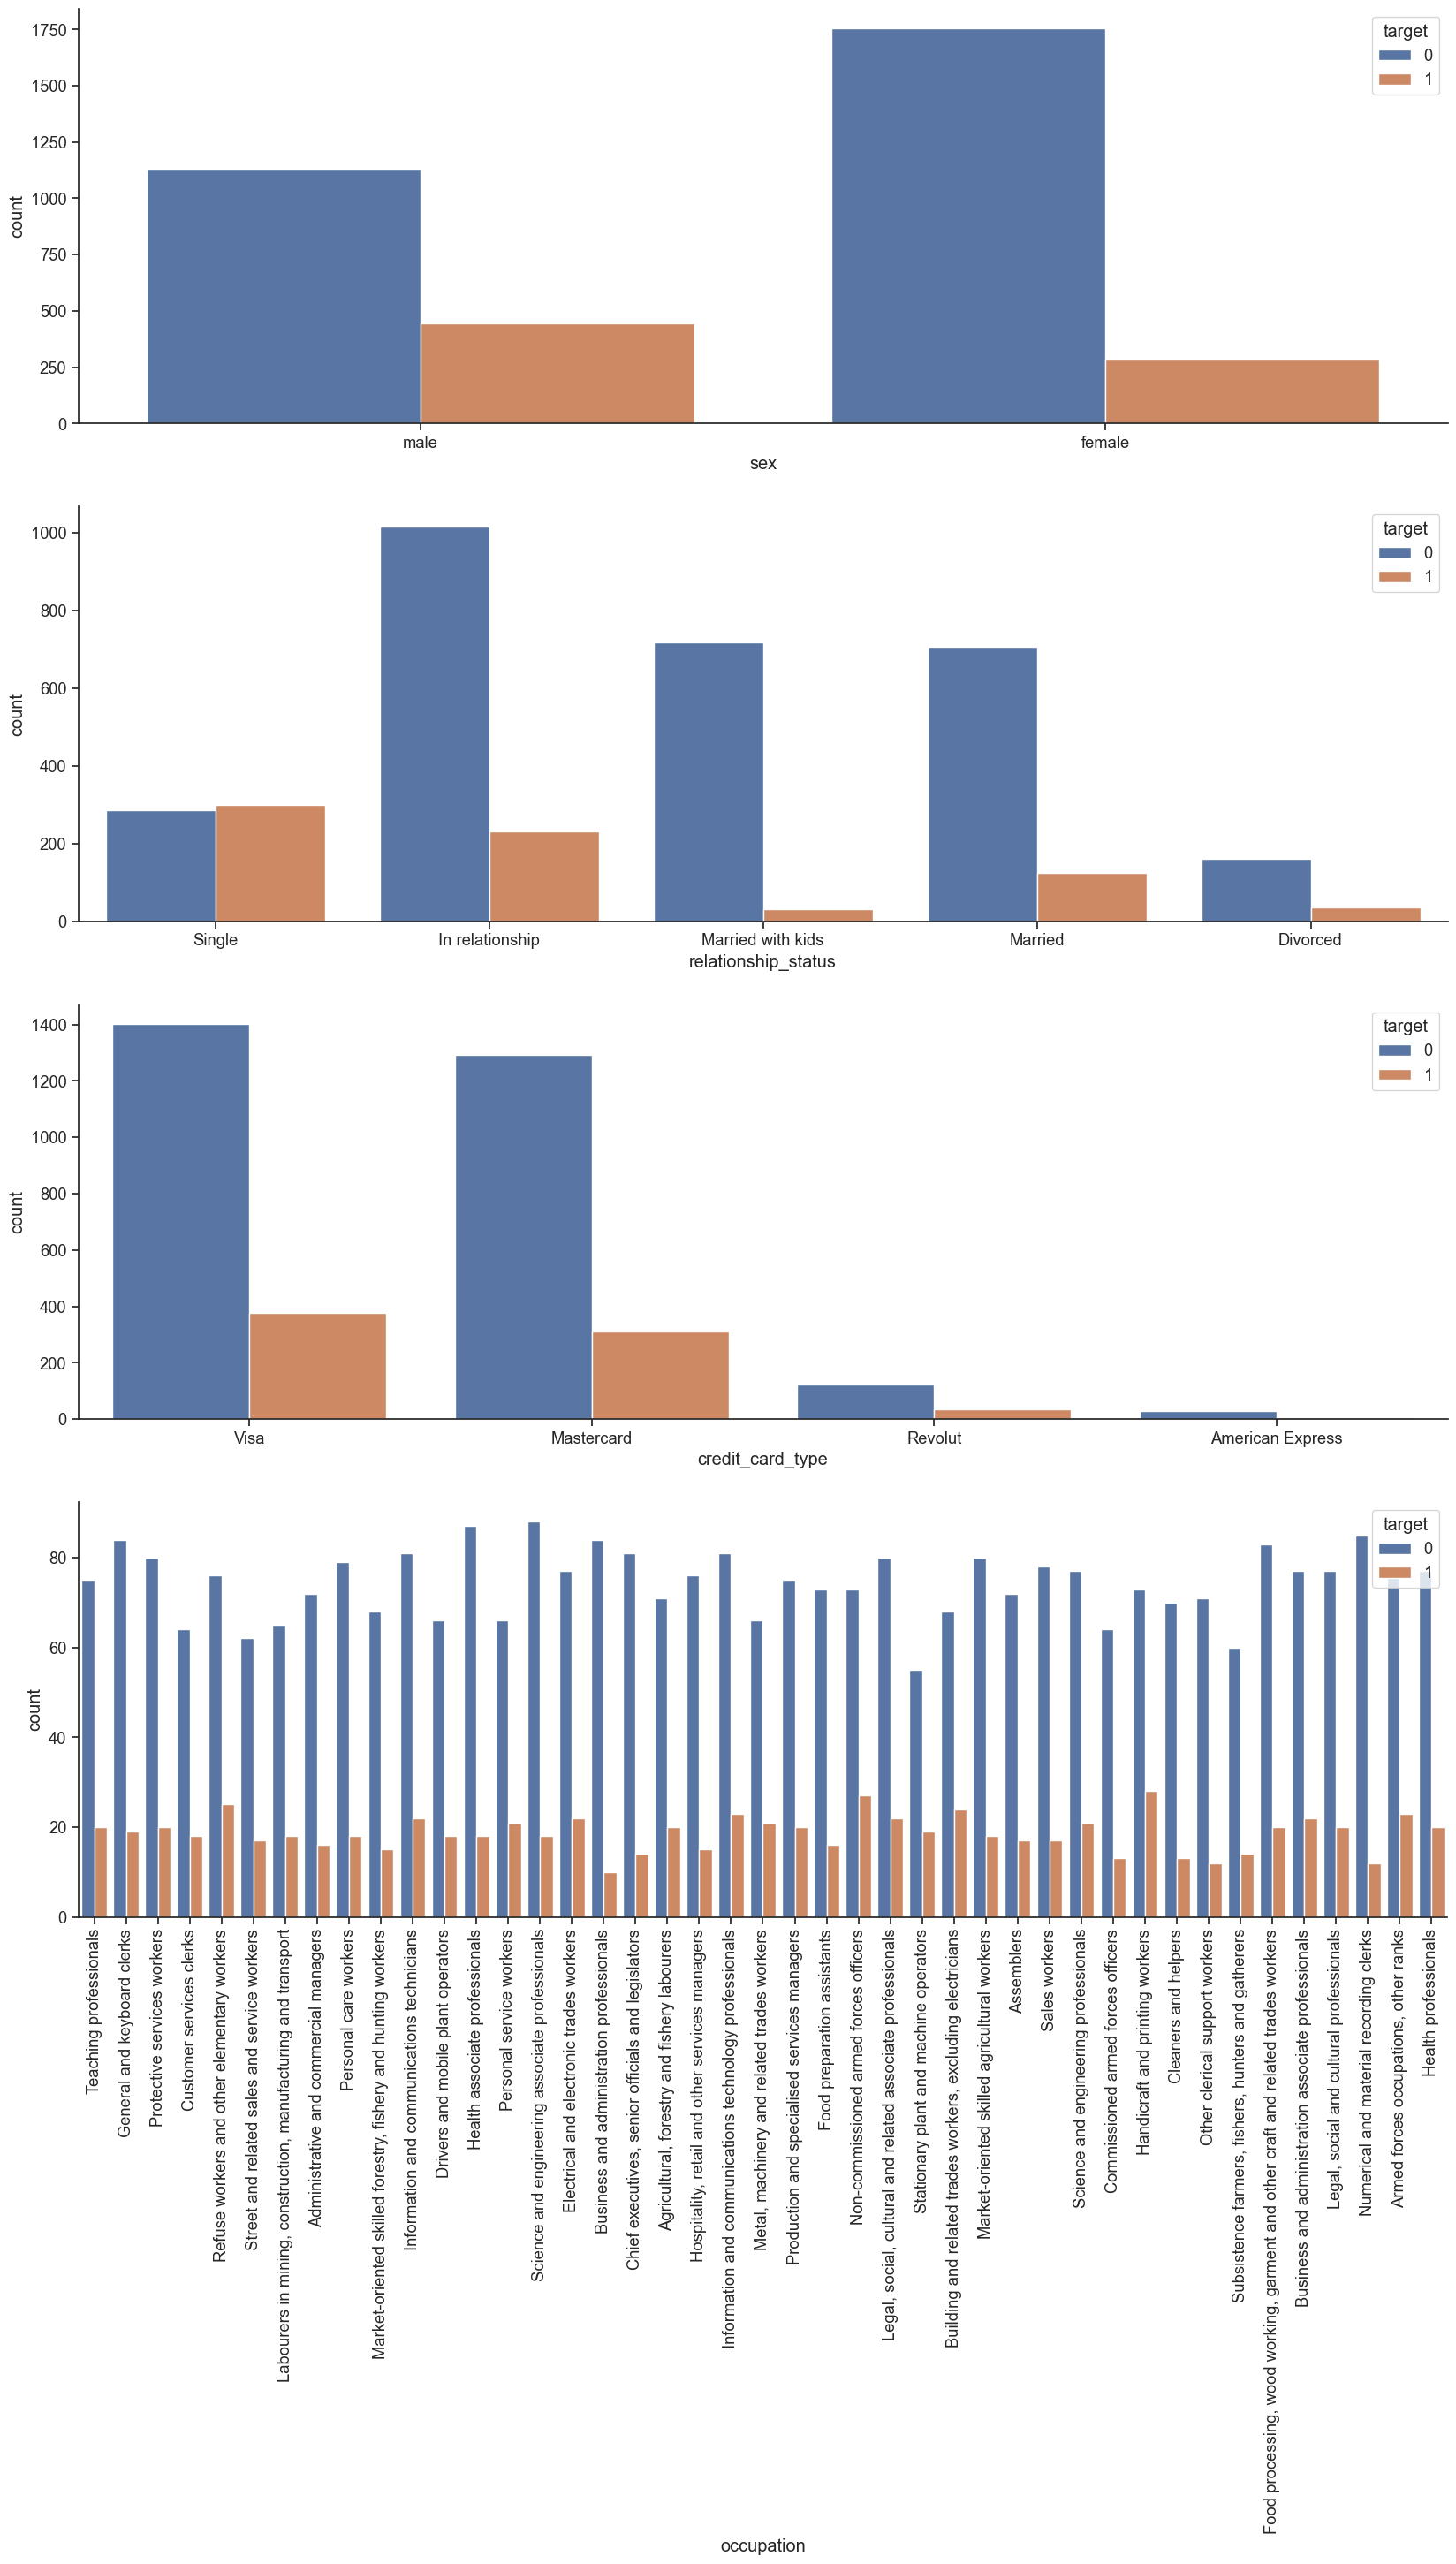

In [169]:
char_cols = ['sex', 'relationship_status', 'credit_card_type', 'occupation']

plt.figure(figsize=(20, 50))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(char_cols):
    plt.subplot(7, 1, i+1)
    ax = sns.countplot(data=df, x=feature, hue='target') 

    # For the occupation chart, rotate the inscription 90 degrees
    if feature == "occupation":
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

sns.despine()


Our target group is singles, you can see this because this is the only group in which we have more people who are our target than the others.

In [170]:
df[['relationship_status','target']].groupby(['relationship_status'], as_index=False).mean().sort_values(by='target')

,relationship_status,target
3,Married with kids,0.042724
2,Married,0.149398
0,Divorced,0.178571
1,In relationship,0.185245
4,Single,0.512821


The table above shows that 51% of the people we target are singles

In [171]:
df['relationship_status'].value_counts()

relationship_status
In relationship      1247
Married               830
Married with kids     749
Single                585
Divorced              196
Name: count, dtype: int64

In [172]:
df[['sex','target']].groupby(['sex'], as_index=False).mean().sort_values(by='target')

,sex,target
0,female,0.139706
1,male,0.282995


In [173]:
df['sex'].value_counts()

sex
female    2040
male      1576
Name: count, dtype: int64

In [174]:
# Percentage of people who are targeted in a given occupational group
result_1 = df[['occupation','target']].groupby(['occupation'], as_index=False).mean().sort_values(by='target', ascending=False)
result_1['target'] = (result_1['target'] * 100).round(2)
result_1.rename(columns={'target': 'target [%]'}, inplace=True)

# The most popular occupations
occupation_counts_df = df['occupation'].value_counts().reset_index()
occupation_counts_df.columns = ['occupation', 'count']
occupation_counts_df

result_1_style = result_1.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("Percentage of people who are targeted in a given occupational group")
occupation_counts_df_style = occupation_counts_df.style.set_table_attributes("style='display:inline'").set_caption("The most popular occupations")

display_html(result_1_style._repr_html_() + occupation_counts_df_style._repr_html_(), raw=True)

,occupation,target [%]
16,Handicraft and printing workers,27.720000
28,Non-commissioned armed forces officers,27.000000
4,"Building and related trades workers, excluding electricians",26.090000
39,Stationary plant and machine operators,25.680000
35,Refuse workers and other elementary workers,24.750000
27,"Metal, machinery and related trades workers",24.140000
32,Personal service workers,24.140000
2,"Armed forces occupations, other ranks",23.000000
12,Electrical and electronic trades workers,22.220000
5,Business and administration associate professionals,22.220000


You can see that the occupation of people is very diverse.

In [175]:
df[['credit_card_type','target']].groupby(['credit_card_type'], as_index=False).mean().sort_values(by='target')

,credit_card_type,target
1,Mastercard,0.194011
0,American Express,0.200000
3,Visa,0.211030
2,Revolut,0.229299


In [176]:
df['credit_card_type'].value_counts()

credit_card_type
Visa                1777
Mastercard          1603
Revolut              157
American Express      35
Name: count, dtype: int64

#### Quantitative variables

In [177]:
num_cols = ['location_population', 'daily_commute', 'friends_number', 'education']

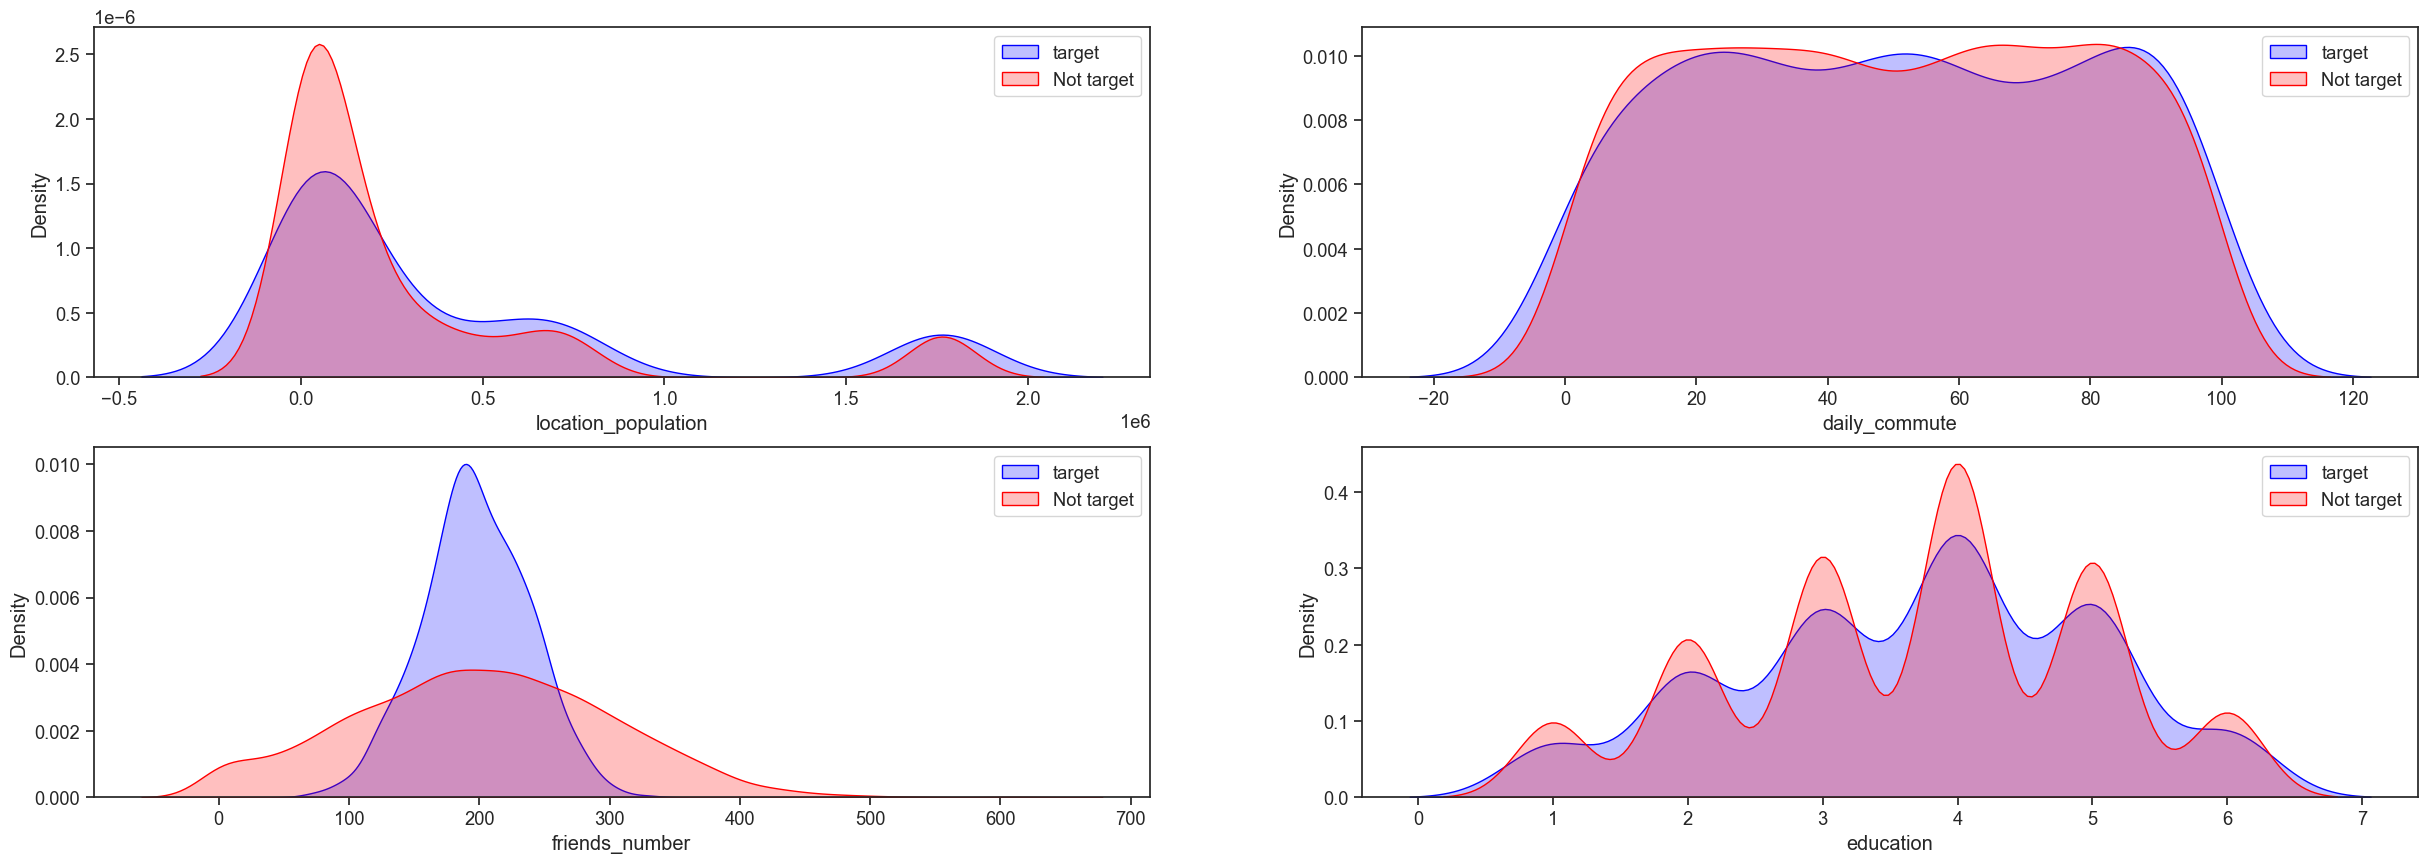

In [178]:
plt.figure(figsize=(30, 10))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    ax = sns.kdeplot(df[feature][df['target'] == 1], color="blue", shade=True)
    sns.kdeplot(df[feature][df['target'] == 0], color="red", shade=True)
    plt.legend(['target', 'Not target'])
    ax.set(xlabel=feature)

We can observe that the distribution of the number of friends is not equal for targeted and non-targeted people. We can see that we are interested in customers who have between 150 and 250 friends.

In [179]:
# Mean and median values of quantitative variables by target variable
df.groupby('target').agg({'location_population': ['mean', 'median'],
                           'daily_commute': ['mean', 'median'],
                           'friends_number': ['mean', 'median'],
                           'education': ['mean', 'median']})

location_population           daily_commute        friends_number  \
                      mean    median          mean median           mean   
target                                                                     
0            287938.329368   74312.0     50.027206   50.0     200.512210   
1            400341.964020  113621.0     50.380495   50.5     197.363524   

              education         
       median      mean median  
target                          
0       200.0  3.665391    4.0  
1       196.0  3.693166    4.0

# Feature engineering, data cleaning

In [180]:
data = df.copy()

# Creating a mapping
mapping = {'male': 0, 'female': 1}

# Changing the value of the 'sex' column
data['sex'] = data['sex'].map(mapping)


In [181]:

data['dob'] = datetime.now().year - data['dob'].dt.year
data.drop(['name'], axis=1, inplace=True)
X = data.drop('target',axis=1)
y = data['target']

# Division of the dataset into training and test datasets

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

X_train_v = X_train.copy()
X_test_v = X_test.copy()

In [183]:
y_train_na = y_train.isna().sum()
y_test_na = y_test.isna().sum()
X_test_na = X_test.isna().sum()
X_train_na = X_train.isna().sum()

In [184]:
data_na(X_train)

,Not NA Count,NA Count,NA Percent
sex,2531,269,9.61%
dob,2525,275,9.82%
location,2800,0,0.00%
location_population,2800,0,0.00%
occupation,2800,0,0.00%
hobbies,2322,478,17.07%
daily_commute,2521,279,9.96%
friends_number,2800,0,0.00%
relationship_status,2518,282,10.07%
education,2501,299,10.68%


Checking how there are missing data in the variable X_train

In [185]:
X_train['sex'].skew()

-0.27209941199537774

In [186]:
X_test['sex'].skew()

-0.22851523391411618

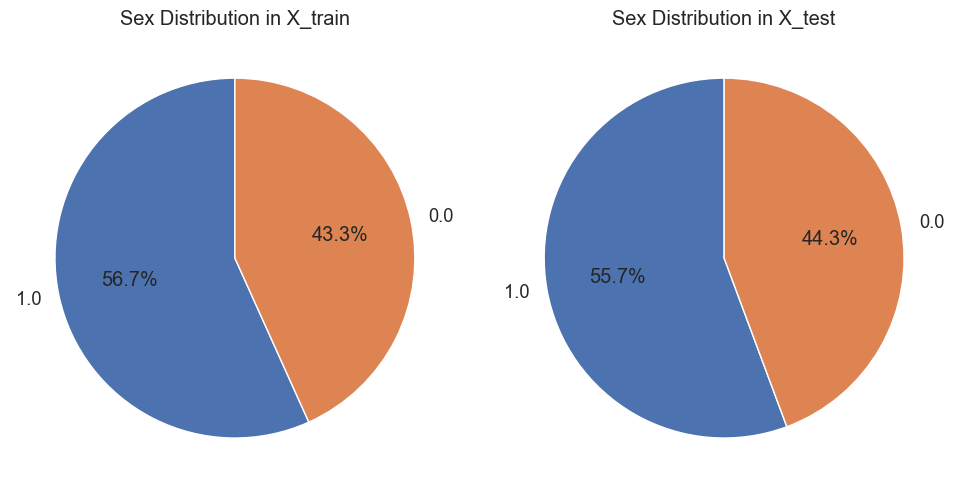

In [187]:
# Creating two pie charts
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Pie chart for X_train
sex_counts_train = X_train['sex'].value_counts()
axes[0].pie(sex_counts_train, labels=sex_counts_train.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Sex Distribution in X_train')

# Pie chart for X_test
sex_counts_test = X_test['sex'].value_counts()
axes[1].pie(sex_counts_test, labels=sex_counts_test.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Sex Distribution in X_test')

plt.tight_layout()  # To ensure adequate distance between charts
plt.show()


# Handling missing data

In [188]:
def get_mode(x):
    mode = scipy.stats.mode(x)
    return mode.mode

In [189]:
X_train = pd.DataFrame(X_train)
sex_mode = X_train.groupby(['education', 'relationship_status']).agg({'sex': get_mode})
sex_mode.reset_index(inplace=True)
sex_mode.head()

,education,relationship_status,sex
0,1.0,Divorced,1.0
1,1.0,In relationship,0.0
2,1.0,Married,0.0
3,1.0,Married with kids,1.0
4,1.0,Single,1.0


In [190]:
X_train = pd.merge(X_train, sex_mode, how='left', on=['education', 'relationship_status'])
# Completion of missing data in the sex column
X_train['sex'] = np.where(X_train['sex_x'].isna(), X_train['sex_y'].round(), X_train['sex_x'])
X_train.drop(['sex_x', 'sex_y'], axis=1, inplace=True)
X_train.head()

,dob,location,location_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type,sex
0,34.0,Chrzanów,37123,Numerical and material recording clerks,"Stretching,Cooking,Parkour",32.0,268,In relationship,3.0,Visa,1.0
1,36.0,Konstancin-Jeziorna,17191,Production and specialised services managers,"Squash,Cardio,Astronomy",5.0,204,In relationship,3.0,Mastercard,0.0
2,23.0,Stalowa Wola,61903,Personal care workers,"Cardio,Power bike,Wood carving,Acting,Rappelling",18.0,128,In relationship,3.0,Visa,1.0
3,56.0,Braniewo,17074,"Armed forces occupations, other ranks","Bodybuilding,Fitness,Skimboarding",76.0,156,Married with kids,5.0,Visa,1.0
4,37.0,Sieniawa,2146,General and keyboard clerks,"Cardio,Rowing,Gym,Dowsing",45.0,182,In relationship,5.0,Visa,0.0


In [191]:
def fill_missing_with_mode(dataframe, column_name):
    mode_value = dataframe[column_name].mode()[0]  # Calculating the dominant for a given column
    dataframe[column_name].fillna(mode_value, inplace=True)  # Filling in missing values with the dominant for the given column

In [192]:
fill_missing_with_mode(X_train, 'sex')
X_train.isna().sum()

dob                    275
location                 0
location_population      0
occupation               0
hobbies                478
daily_commute          279
friends_number           0
relationship_status    282
education              299
credit_card_type       302
sex                      0
dtype: int64

We do not see large deviations, so we can see that the data has been correctly imputed

In [193]:
df1 = pd.DataFrame(X_train['sex'].describe())
df2 = pd.DataFrame(X['sex'].describe())

df1_style = df1.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("DF X_train table")
df2_style = df2.style.set_table_attributes("style='display:inline'").set_caption("DF X all table")

display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)

,sex
count,2800.000000
mean,0.591429
std,0.491658
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000
,sex
count,3616.000000


Comparison of data representing gender for training and baseline data

In [194]:
# Define a function to calculate the mode (most common value) of a numeric column.
def get_mode(x):
    if x.dtype.name != 'object': # Check if the column type is not 'object' (numeric)
        mode = scipy.stats.mode(x) # Calculate the mode using scipy.stats.mode() function
        if len(mode.mode) > 0: # Check if there is at least one mode value
            return mode.mode[0]  # Return the first mode value as the result
    return None

# Define a function to impute missing values in a DataFrame column based on group-wise aggregation.
def imp_grup(df, group, col, method):
    train = df.groupby(group).agg({col: method}).reset_index() # Group the DataFrame by specified 'group' columns and calculate 'method' for 'col'
    agg_all = df.groupby(group).agg({col: method}).reset_index() # Duplicate the aggregation result for later merging
    df = pd.merge(df, train, how='left', on=group) # Merge the aggregation result back into the original DataFrame using 'group' as the key
    df[col] = np.where(df[f'{col}_x'].isna(), df[f'{col}_y'], df[f'{col}_x']) # Use np.where to replace missing values in 'col' with values from the aggregated result
    df.drop([f'{col}_x', f'{col}_y'], axis=1, inplace=True) # Drop the duplicated columns created during the merge.
    return df

X_train = imp_grup(X_train, ['sex', 'education'], 'credit_card_type', get_mode)

In [195]:
X_train = imp_grup(X_train, ['sex', 'education'], 'credit_card_type', get_mode)
fill_missing_with_mode(X_train, 'credit_card_type')

In [196]:
def count_variable_percentage(df, column_name):
    # Calculating the counts of individual variables
    variable_counts = df[column_name].value_counts()

    # Calculating the percentage contribution
    variable_percentages = (variable_counts / len(df)) * 100

    # Creating the result table
    result_table = pd.DataFrame({
        'Variable': variable_counts.index,
        'Count': variable_counts.values,
        'Percentage Share': variable_percentages.values
    })

    # Sorting the table by percentage share in descending order
    result_table = result_table.sort_values(by='Percentage Share', ascending=False)

    return result_table

In [197]:
df1 = count_variable_percentage(X_train, 'credit_card_type')
df2 = count_variable_percentage(X, 'credit_card_type')

df1_style = df1.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("DF X_train table")
df2_style = df2.style.set_table_attributes("style='display:inline'").set_caption("DF X all table")

display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)

,Variable,Count,Percentage Share
0,Visa,1533,54.750000
1,Mastercard,1136,40.571429
2,Revolut,108,3.857143
3,American Express,23,0.821429
,Variable,Count,Percentage Share
0,Visa,1777,44.425000
1,Mastercard,1603,40.075000
2,Revolut,157,3.925000
3,American Express,35,0.875000


In [198]:
X_train = imp_grup(X_train, ['sex', 'education'], 'relationship_status', get_mode)
X_train.dtypes

dob                    float64
location                object
location_population      int64
occupation              object
hobbies                 object
daily_commute          float64
friends_number           int64
education              float64
sex                    float64
credit_card_type        object
relationship_status     object
dtype: object

In [199]:
X_train[['education']] = X_train[['education']].astype(object) # change of data type to object
fill_missing_with_mode(X_train, 'relationship_status')

X_train = imp_grup(X_train, ['sex', 'relationship_status'], 'education', get_mode)
fill_missing_with_mode(X_train, 'education')

X_train = imp_grup(X_train, ['sex', 'relationship_status'], 'dob', 'mean')
X_train = imp_grup(X_train, ['sex', 'relationship_status'], 'daily_commute', 'mean')

Now we only have nan values in the column hobbies

In [200]:
X_train.isna().sum()

location                 0
location_population      0
occupation               0
hobbies                478
friends_number           0
sex                      0
credit_card_type         0
relationship_status      0
education                0
dob                      0
daily_commute            0
dtype: int64

In [201]:
# Saving the prepared data to csv files
X_train.to_csv("data/for_model.csv")
y_train.to_csv("data/for_model_y.csv")

# Data transformation for applying the trained model.

Aggregate application of transforming functions 

In [202]:
def inp_all(df):
    fill_missing_with_mode(df, 'sex')

    df = imp_grup(df, ['sex', 'education'], 'credit_card_type', get_mode)
    fill_missing_with_mode(df, 'credit_card_type')

    df = imp_grup(df, ['sex', 'education'], 'relationship_status', get_mode)

    df[['education']] = df[['education']].astype(object) # change of data type to object
    fill_missing_with_mode(df, 'relationship_status')

    df = imp_grup(df, ['sex', 'relationship_status'], 'education', get_mode)
    fill_missing_with_mode(df, 'education')

    df = imp_grup(df, ['sex', 'relationship_status'], 'dob', 'mean')
    df = imp_grup(df, ['sex', 'relationship_status'], 'daily_commute', 'mean')

    return df

In [203]:
def hobbies_100(df):
    hobby_columns = df['hobbies'].str.get_dummies(',') # Save hobbies column as one hot encorder
    hobb = hobby_columns.sum().sort_values(ascending=False) # Sorting from largest to smallest
    hobb_100 = hobb[hobb > 100] # Choosing hobbies that repeat 100 or more times
    return hobby_columns[hobb_100.index] # saving the selected hobbies

In [204]:
def hobby_global(df):
    return hobbies_100(df).columns

Global variable that stores the selected hobby

In [205]:
hobby_global = hobby_global(X_train.dropna())

Training the model on the training group and then applying the model to the data for the group with barracking data. -> creating a df with the results  
Each column has its own Logistic regression model

In [206]:
# Function that converts columns with 0 or 1 into a single column
def hot_encoder_revers(row):

    indices_with_one = [index for index, row in enumerate(row) if row == 1]

    if not indices_with_one: # person does not have a hobby 
        return 0
    elif len(indices_with_one) > 1: # He has one hobby
        return 13
    else: # Has more than one hobby
        return indices_with_one[0] + 1

Preparation of one variable that represents the hobby.  

The numbers sequentially represent:  
- 0 -> person does not have a hobby  
- 1 -> Gym
- 2 -> Squash
- 3 -> Bodybuilding	
- 4 -> Rowing
- 5 -> Cardio
- 6 -> Weightlifting
- 7 -> Badminton
- 8 -> Crossfit
- 9 -> Fitness
- 10 -> Stretching
- 11 -> Power bike
- 12 -> Kettleballs
- 13 -> Has more than one hobby

In [207]:
def one_hot_column(df, col):
    hot_col = df[col].str.get_dummies() # Application of one hot encoding
    return hot_col.drop(hot_col.columns[0], axis=1) # reduction in the number of columns

In [208]:
def t_function(df):
    hot_credit_card_type = one_hot_column(df,'credit_card_type')
    hot_relationship_status = one_hot_column(df,'relationship_status')

    # Linking tables with data as one hot encoder
    df = pd.concat([df, hot_relationship_status], axis=1)
    df = pd.concat([df, hot_credit_card_type], axis=1)

    df = df.drop(columns=['location', 'occupation', 'credit_card_type', 'hobbies', 'relationship_status']) # Deleting columns
    return df

In [209]:
def hobby_test(df):
    hobby_columns = df['hobbies'].str.get_dummies(',') # Save hobbies column as one hot encorder
    return hobby_columns[hobby_global]

In [210]:
def predict_hobby(df):
    with open('models/all_trained_hobby_models.pkl', 'rb') as f:
        trained_models = pickle.load(f)

    # Necessary to maintain correct order of columns
    df = df[['location_population', 'friends_number', 'sex', 'education', 'dob',
       'daily_commute', 'In relationship', 'Married', 'Married with kids',
       'Single', 'Mastercard', 'Revolut', 'Visa']]

    pred_hobby = pd.DataFrame()

    for hobby, model in trained_models.items():
        pred = model.predict(df)
        pred_hobby[hobby] = pred

    return pred_hobby

In [211]:
def transform_hbb(df):
    t_df = df[df.isna().any(axis=1)]
    n_df = df.dropna()

    t_df = t_function(t_df) # Data ready to use predictive model

    hobby = hobby_test(n_df)

    n_df[hobby_global] = hobby
    n_df = t_function(n_df)

    t_df.reset_index(inplace=True)
    t_df[hobby_global] = predict_hobby(t_df)
    t_df.set_index('index', inplace=True)

    df_all = pd.concat([t_df, n_df], axis=0)
    df_all = df_all.sort_index(ascending=True)

    return df_all

Application of transforming models

In [212]:
def transform_full(df):
    df = inp_all(df)
    df = transform_hbb(df)
    return df

Application of data completion models

In [213]:
# Turning multiple hobby columns into a single column

def hobbies_to_one(df):
    df['hobbies'] = df[hobby_global].apply(hot_encoder_revers, axis=1).values
    df.drop(columns=hobby_global, inplace=True)
    return df

In [214]:
def matric_cf(y_test, y_pred):
    # Creating a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualization of the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()

    classes = ['Class 0', 'Class 1']  
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicated')
    plt.ylabel('True')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.show()

In [215]:
def roc_dg(model, X_test, y_test):

    # Calculating the probabilities of belonging to a positive class
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except: # Condition added for XGBoost model
        y_prob = model.predict(dtest, output_margin=True)
        # y_prob = model.predict(dtest)
        y_prob = 1.0 / (1.0 + np.exp(-y_prob))  # Apply sigmoid function to convert to probability
        y_prob = y_prob[:, 1]

    # Obliczanie krzywej ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculation of area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # ROC curve graph
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [216]:
# Hobby in multiple columns
X_test_t = transform_full(X_test_v)
X_train_t = transform_full(X_train_v)

# Hobbies in one column
X_test_one = hobbies_to_one(X_test_t)
X_train_one = hobbies_to_one(X_train_t)

# Logistic Regression

## Checking the results for the training set

In [217]:
# creation of logistic regression model and fitting to training set
model = LogisticRegression(random_state=42)
model.fit(X_train_one, y_train)

# prediction for training set
y_pred_lr = model.predict(X_train_one)

accuracy_lr_ = accuracy_score(y_train, y_pred_lr)
print("Accuracy: %.2f%%" % (accuracy_lr_ * 100.0))

Accuracy: 79.75%


## Checking the results for the test set

In [218]:
y_pred_test_lr = model.predict(X_test_one)
accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))

Accuracy: 80.08%


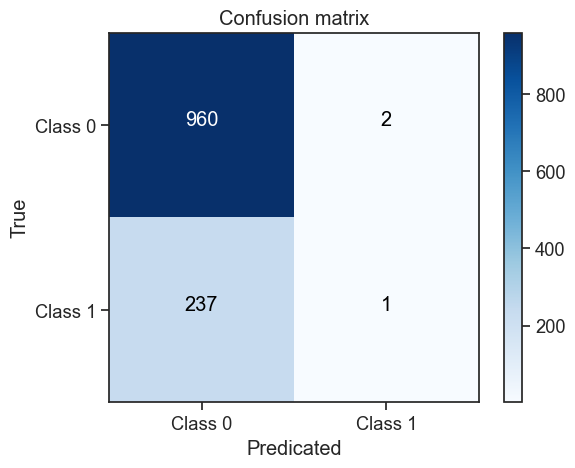

In [219]:
matric_cf(y_test, y_pred_test_lr)

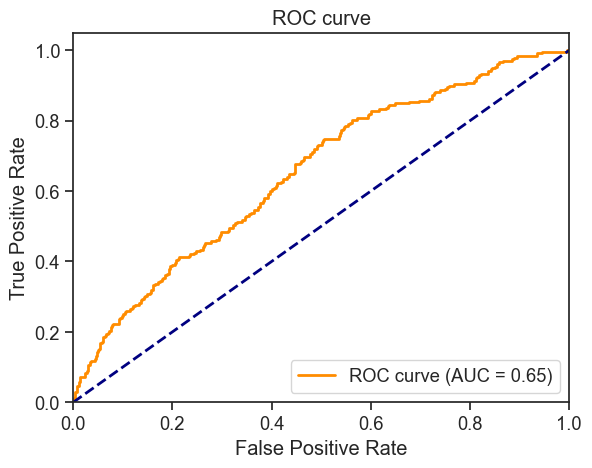

In [220]:
roc_dg(model, X_test_one, y_test)

# XGBoost

In [221]:
# Create a DMatrix object for training and test data
dtrain = xgb.DMatrix(data=X_train_one, label=y_train)
dtest = xgb.DMatrix(data=X_test_one)

# Define the hyperparameter grid for grid search
param_grid = {
    'max_depth': [3, 4, 5],  # List of max_depth values to search
    'eta': [0.1, 0.2, 0.3],  # List of learning rates to search
    'num_class': [len(data['target'].unique())],  # Number of unique classes in 'target'
    'eval_metric': ['merror']  # Evaluation metric
}

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax')

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_one, y_train)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model_g = grid_search.best_estimator_

# Making predictions on test data using the best model
y_pred_xgb_g = best_model_g.predict(X_test_one)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluation of classification results
accuracy_xgb_g = accuracy_score(y_test, y_pred_xgb_g)
print("Accuracy: %.2f%%" % (accuracy_xgb_g * 100.0))


Best Hyperparameters: {'eta': 0.1, 'eval_metric': 'merror', 'max_depth': 3, 'num_class': 2}
Accuracy: 85.42%


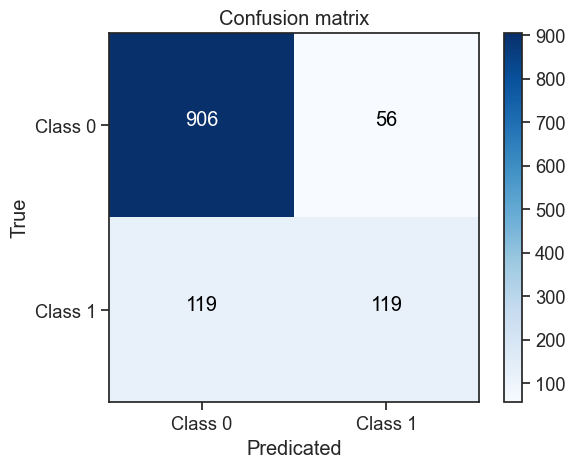

In [222]:
matric_cf(y_test, y_pred_xgb_g)

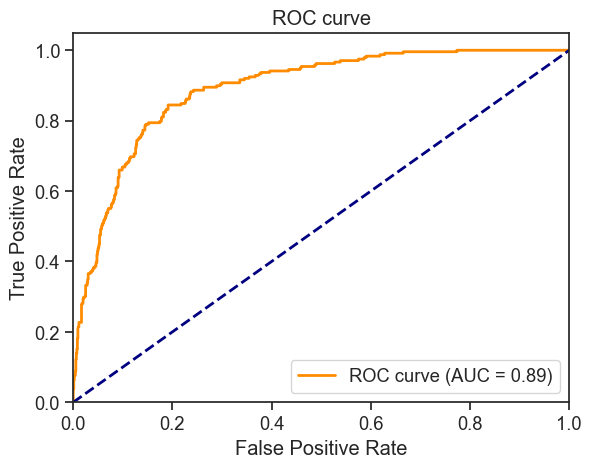

In [223]:
roc_dg(best_model_g, X_test_one, y_test)

In [224]:
# Create a DMatrix object for training and test data
dtrain = xgb.DMatrix(data=X_train_one, label=y_train)
dtest = xgb.DMatrix(data=X_test_one)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': np.arange(3, 10),      # Range of max_depth values to search
    'eta': [0.1, 0.01, 0.001],          # Learning rate values to search
    'gamma': [0, 0.1, 0.2, 0.3],       # Gamma values to search
    'subsample': [0.6, 0.7, 0.8, 0.9], # Subsample values to search
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],  # colsample_bytree values to search
}

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='merror'
)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=param_grid,
    n_iter=10,  # Number of random parameter combinations to try
    scoring='accuracy',  # Use an appropriate scoring metric
    cv=3,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_one, y_train)

# Get the best model from RandomizedSearchCV
best_model_r = random_search.best_estimator_

# Make predictions on test data using the best model
y_pred_xgb_r = best_model_r.predict(X_test_one)

# Print the best parameters and the accuracy of the best model
print("Best Parameters:", random_search.best_params_)

# Evaluation of classification results
accuracy_xgb_r = accuracy_score(y_test, y_pred_xgb_r)
print("Accuracy: %.2f%%" % (accuracy_xgb_r * 100.0))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.6, 'max_depth': 8, 'gamma': 0.2, 'eta': 0.01, 'colsample_bytree': 0.8}
Accuracy: 86.00%


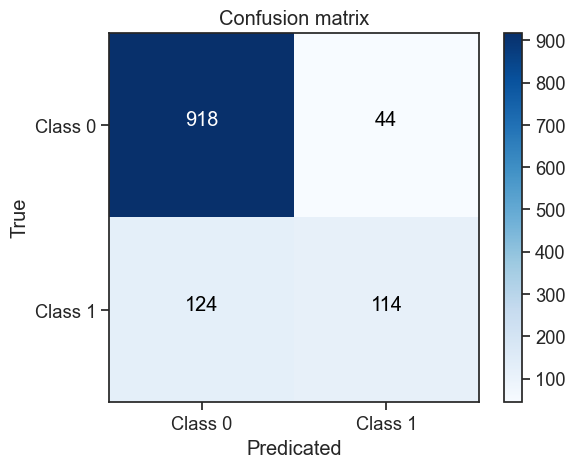

In [225]:
matric_cf(y_test, y_pred_xgb_r)

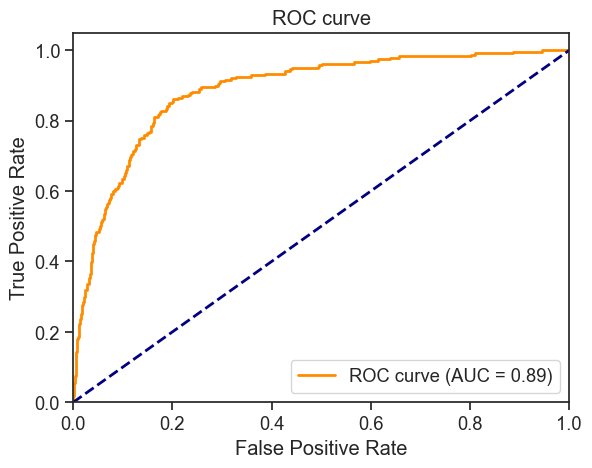

In [226]:
roc_dg(best_model_r, X_test_one, y_test)

# Decision trees

In [227]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_one, y_train)
y_pred_dt = clf.predict(X_test_one)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy: %.2f%%" % (accuracy_dt * 100.0))

Accuracy: 82.00%


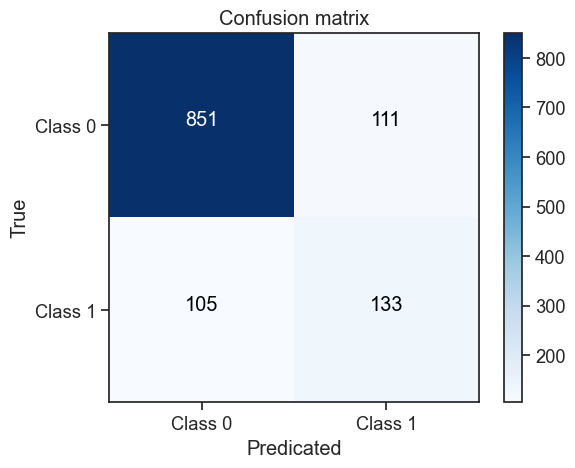

In [228]:
matric_cf(y_test, y_pred_dt)

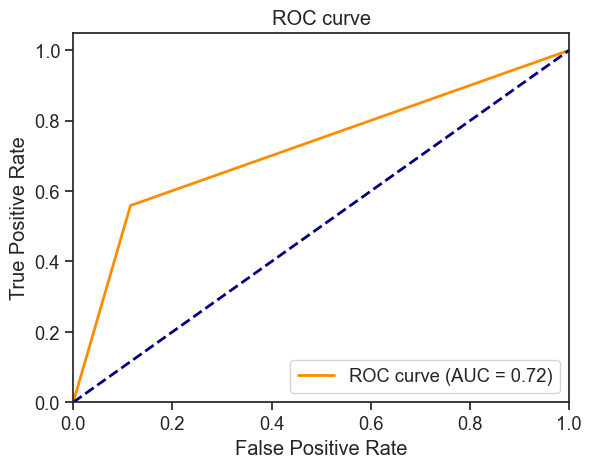

In [229]:
roc_dg(clf, X_test_one, y_test)

# Decision trees with RFE  

RFE - Recursive Feature Elimination

In [230]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

pipeline.fit(X_train_one, y_train)

y_pred_dt_rfe = pipeline.predict(X_test_one)

accuracy_dt_rfe = accuracy_score(y_test, y_pred_dt_rfe)
print("Accuracy: %.2f%%" % (accuracy_dt_rfe * 100.0))

Accuracy: 78.25%


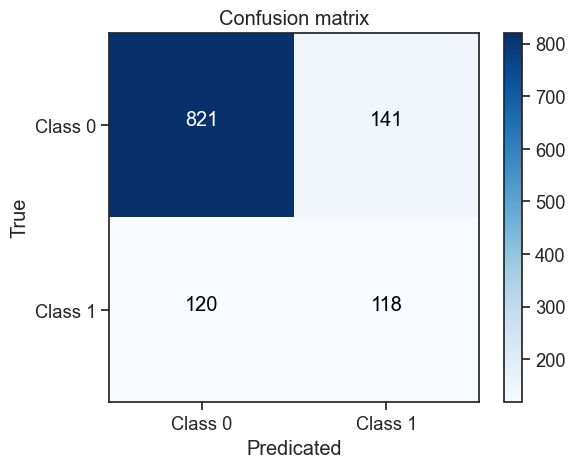

In [231]:
matric_cf(y_test, y_pred_dt_rfe)

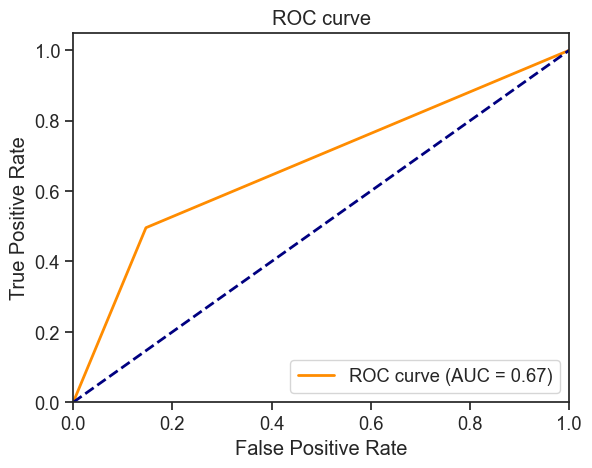

In [232]:
roc_dg(pipeline, X_test_one, y_test)

# Suport Vector Machine (SVM)

In [233]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_one)
X_test = scaler.transform(X_test_one)

# Create an SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', C=1, probability=True)

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy_svm * 100.0))

Accuracy: 83.42%


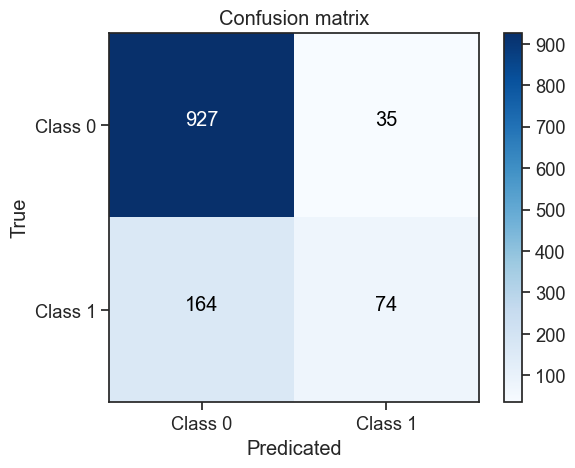

In [234]:
matric_cf(y_test, y_pred_svm)

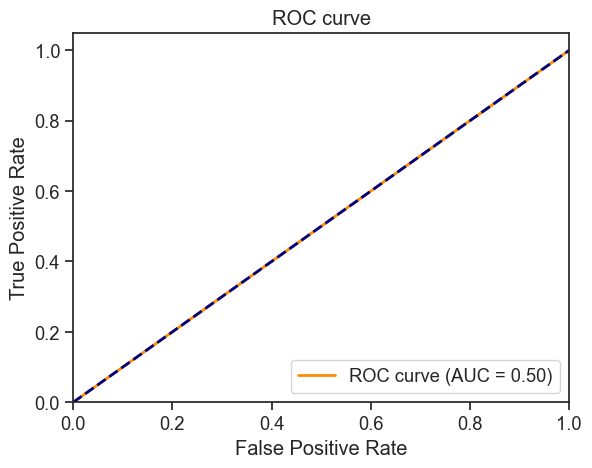

In [235]:
roc_dg(svm_classifier, X_test_one, y_test)

# Pledge of models

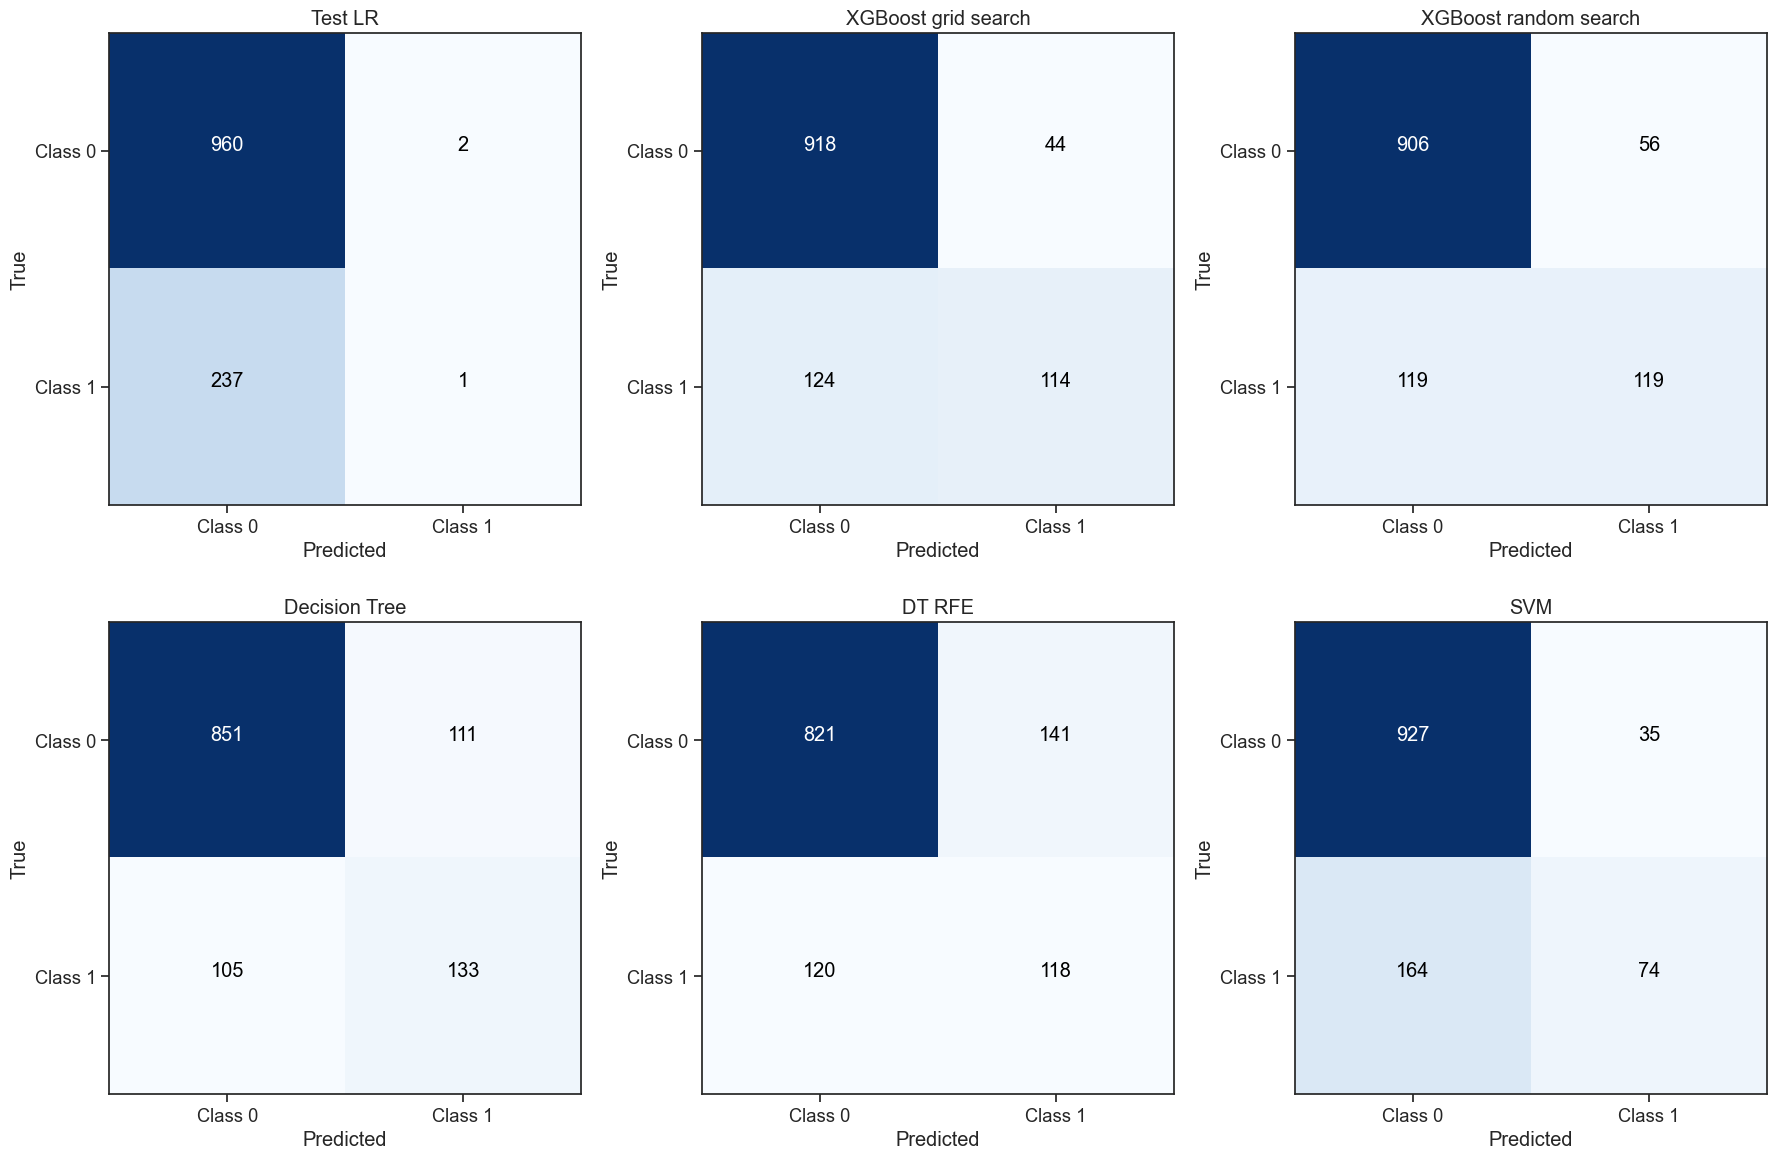

In [236]:
def matric_cf(ax, y_test, y_pred, title):
    # Creating a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix on the given subplot
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)

    classes = ['Class 0', 'Class 1']  
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, str(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

# Create subplots and display confusion matrix in 3x2 layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flattening the subplot array

# List of titles
titles = ['Test LR', 'XGBoost grid search', 'XGBoost random search', 'Decision Tree', 'DT RFE', 'SVM']

# List of prediction results
y_preds = [y_pred_test_lr, y_pred_xgb_r, y_pred_xgb_g, y_pred_dt, y_pred_dt_rfe, y_pred_svm]

# Display confusion matrix in each subplot
try:
    for i, ax in enumerate(axes):
        matric_cf(ax, y_test, y_preds[i], titles[i])
except:
    pass

plt.tight_layout()
plt.show()
